## SMS Spam Collection Dataset

### Context

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content


The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: http://www.grumbletext.co.uk/. -> A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/. -> A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis.

### Contents of this notebook

* #### TEXT ANALYSIS
        - Having a peek at the Data
        - Developing Insights
* #### TEXT TRANSFORMATION
        - Data Cleaning (Removing unimportant data/ Stopwords/ Stemming)
        - Converting data into a model usable format (Bag of words/ Tfidf Model)
* #### MODEL APPLICATION


#### TEXT ANALYSIS

In [7]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['patch.force_edgecolor'] = True

# Text Preprocessing
import nltk
# nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

In [8]:
messages = pd.read_csv("spam.csv", encoding = 'latin-1')

# Drop the extra columns and rename columns

messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["category", "text"]

In [9]:
display(messages.head(n = 10))

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [10]:
# Lets look at the dataset info to see if everything is alright

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
category    5572 non-null object
text        5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


##### Lets see what precentage of our data is spam/ham

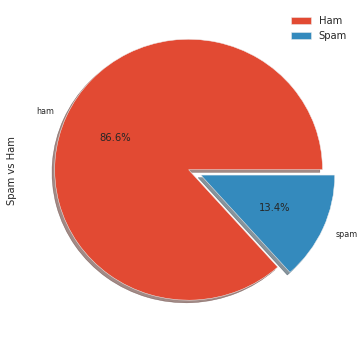

In [11]:
messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

A lot of messages are actually not spam. About 86% of our dataset consists of normal messages.

*  While we split our data set into train and test or when we use cross validation, we will have to use stratified sampling, otherwise we have a chance of our training model being skewed towards normal messages. If the sample we choose to train our model consists majorly of normal messages, it may end up predicting everything as ham and we might not be able to figure this out since most of the messages we get are actually ham and will have a pretty good accuracy.
    
* A very basic model would be a model that predicts everything as ham. It would have a decent accuracy. But then again, is that right? No. We will then have to use an accuracy metric that keeps this in mind. 
    Goal : We don't mind if we miss the odd spam message but we surely don't want to mark a ham message as spam i.e Precision is very important. Hence we will use fbeta score as our accuracy metric with inclination towards Precision

##### Lets see the top spam/ham messages

In [12]:
topMessages = messages.groupby("text")["category"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
text,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


So. People are really busy it seems. "Sorry, i'll call later" tops the ham message list with 30 counts with "I cant pick the phone right now. Pls send a message" comes second with 12 counts.

Theres a quite lot of Ok..., Okie and Ok. in there too :>

##### Lets study individual Spam/ham words

In [13]:
spam_messages = messages[messages["category"] == "spam"]["text"]
ham_messages = messages[messages["category"] == "ham"]["text"]

spam_words = []
ham_words = []

# Since this is just classifying the message as spam or ham, we can use isalpha(). 
# This will also remove the not word in something like can't etc. 
# In a sentiment analysis setting, its better to use 
# sentence.translate(string.maketrans("", "", ), chars_to_remove)

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

print("")

In [14]:
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

In [15]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

NameError: name 'WordCloud' is not defined

In [16]:
#Ham word cloud

ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

NameError: name 'WordCloud' is not defined

In [20]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      217
txt       156
ur        144
u         144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [21]:
# Top 10 Ham words

ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       974
gt      318
lt      316
get     301
ok      246
go      246
got     242
ur      237
know    234
like    231
dtype: int64

#### Does the length of the message indicates us anything?

In [22]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: messageLength, dtype: float64

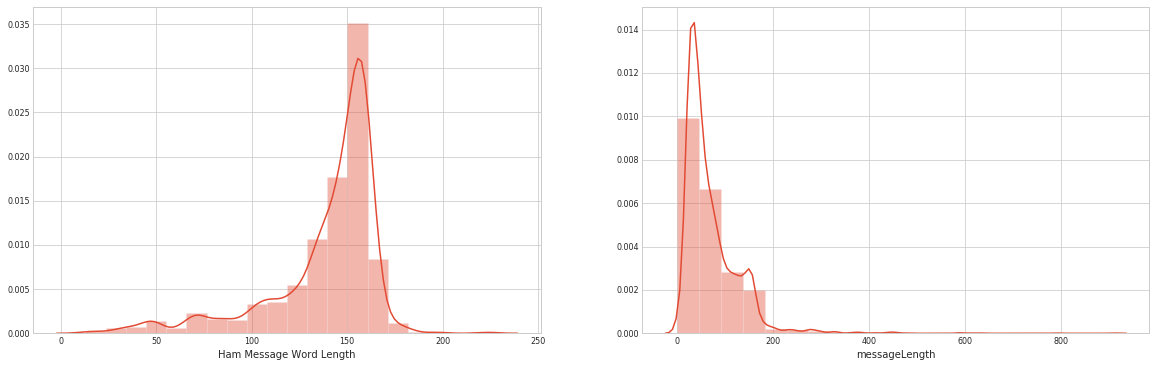

In [23]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["category"] == "spam"]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == "ham"]["messageLength"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

Looks like spam messages are usually longer. Maybe messageLength can become a feature to predict whether the message is spam/ ham ?

#### TEXT TRANSFORMATION

#### Lets clean our data by removing punctuations/ stopwords and stemming words

In [24]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

messages["text"] = messages["text"].apply(cleanText)
messages.head(n = 10)    

,category,text,messageLength
0,ham,go jurong point crazi avail bugi n great world...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri 2 wkli comp win fa cup final tkts 2...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah dont think goe usf live around though,61
5,spam,freemsg hey darl 3 week word back id like fun ...,148
6,ham,even brother like speak treat like aid patent,77
7,ham,per request mell mell oru minnaminungint nurun...,160
8,spam,winner valu network custom select receivea å£9...,158
9,spam,mobil 11 month u r entitl updat latest colour ...,154


##### Lets convert our clean text into a representation that a machine learning model can understand. I'll use the Tfifd for this.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["text"])
features.shape

(5572, 7903)

#### MODEL APPLICATION

In [26]:
def encodeCategory(cat):
    if cat == "spam":
        return 1
    else:
        return 0
        
messages["category"] = messages["category"].apply(encodeCategory)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, messages["category"], stratify = messages["category"], test_size = 0.2)

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score

from sklearn.naive_bayes import MultinomialNB
gaussianNb = MultinomialNB()
gaussianNb.fit(X_train, y_train)

y_pred = gaussianNb.predict(X_test)

print(fbeta_score(y_test, y_pred, beta = 0.5))

0.931623931624


TODO : Use more models/ Include Grid Search to find the most optimal model/ Use Lemma? / Use NER ? etc